##### Run this file to generate the results shown in the paper
###### The data files(.csv) used in this code are generated from preprocessing, for more details see the : pre-processing folder

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## Loading Data


In [3]:
ratio = pd.read_csv('data/sorted-ratio-profit-length(0_5299).csv',header = None)
ratio.columns = ['path_no','ratio','profit','length']

queries = pd.read_csv('data/within-150m-time.csv')
test_queries = queries[(queries['time'] >= 20100000) & (queries['time'] <= 20110000)]
test_queries.reset_index(drop=True, inplace=True)

paths = pd.read_csv('data/train_paths_without_duplicates.csv')
paths=paths.rename(columns = {'Unnamed: 0':'path_no'})
# The property of shortest path is that it will always contain unique nodes

## Generating cache levels
##### Total 1000 cache levels 

In [5]:
def cachelist(cache,sorted_ratio,cumulative_length):
    capacity  = cache * cumulative_length
    b = 0
    a = 0
    cache_pathlist = []
    for i,data in sorted_ratio.iterrows():
        cache_pathlist.append(data[0])
        a += data[3]
        b += 1
        if a>=capacity:
            break
    return cache_pathlist

# Will take few seconds to run
# Will generate a folder named cached

cache = 0.001
cumulative_length = 0
total_paths = 0
for i,data in ratio.iterrows():
    cumulative_length += data[3]
    total_paths += 1
for i in tqdm(range(1000)):
    cache_pathlist = cachelist(cache,ratio,cumulative_length)
#     print(len(cache_pathlist)) 
    pd.DataFrame(cache_pathlist).to_csv('results/cached/cache_'+str("%0.3f"% cache)+'_pathlist.csv',index=False,header=False)
    cache +=0.001

100%|██████████| 1000/1000 [01:00<00:00, 16.66it/s]


## Testing on the unseen Queries

In [6]:
ans =[]
ans.append(0)
cache = 0
cache_id = 0
query = test_queries.copy() 

# Will take few seconds to run
# Will generate a file named "ans.csv"

for z in tqdm(range(1000)):
    cache = cache+0.001
    cache_pathlist = pd.read_csv('results/cached/cache_'+str("%0.3f"% cache)+'_pathlist.csv',header = None)
    y = cache_pathlist.shape[0]
    cache_pathlist = cache_pathlist[cache_id:cache_pathlist.shape[0]]
    cache_id = y
    cache_list = cache_pathlist[0].values.tolist()
    p = paths[paths.path_no.isin(cache_list)]
    p = p.drop(['path_no'],axis =1)
    p = p.apply(pd.to_numeric)
    a = (p.values)
    a.sort(axis=1)
    a = a[:, ::-1]
    len_path = []
    for j,path in enumerate(a):
        l = np.count_nonzero(path+1)
        len_path.append(l)
    answer = 0
    indexes_to_drop=[]
    for i,src_des in query.iterrows():
        des = max(src_des[0],src_des[1])
        src = min(src_des[0],src_des[1])
        for j,path in enumerate(a):
            max_node = path[0]
            min_node = path[len_path[j]-1]
            if des<=max_node and src>=min_node:
                c = 0
                for k in range(len_path[j]):
                    if src == path[k]:
                        c +=1
                    if des == path[k]:
                        c +=1
                if c == 2:
                    answer +=1
                    indexes_to_drop.append(i)
                    break
    ans.append(answer+ans[z])
#     print(z,answer+ans[z])
    query.drop(query.index[indexes_to_drop],inplace = True)
    query.reset_index(drop=True, inplace=True)
# print('queriesAnaswered :',ans)
pd.DataFrame(ans[1:]).to_csv('results/ans.csv',index = False,header = False)

100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


## Plotting unseenQueriesServed vs cacheStored

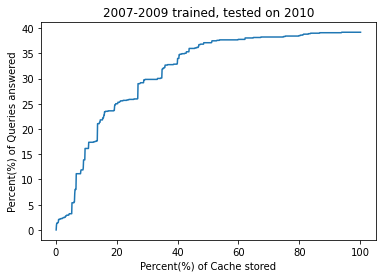

In [7]:
import matplotlib.pyplot as plt
cache =0.001*100
x = [cache*i for i in range(1,len(ans)+1)]
y = [(i/1059)*100 for i in ans]

plt.plot(x,y)
plt.xlabel('Percent(%) of Cache stored')
plt.ylabel('Percent(%) of Queries answered')
plt.title('2007-2009 trained, tested on 2010')
plt.savefig('results/main.eps',dpi = 600)